In [44]:
#Packages 

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSIM
import opentnsim.core as core
import opentnsim.graph_module as graph_module
import opentnsim.plot as plot
import opentnsim.model as model

### Making updated mixin classes

In [45]:
class VesselProperties:
    """Mixin class: Something that has vessel properties

    type: can contain info on vessel type (avv class, cemt_class or other)
    B: vessel width
    L: vessel length
    H_e: vessel height unloaded
    H_f: vessel height loaded
    T_e: draught unloaded
    T_f: draught loaded

    Add information on possible restrictions to the vessels, i.e. height, width, etc.
    """

    def __init__(
        self,
        type,
        B,
        L,
        H_e,
        H_f,
        T_e,
        T_f,
        *args,
        **kwargs
        ):
        super().__init__(*args, **kwargs)

        """Initialization"""
        self.type = type

        self.B = B
        self.L = L

        self.H_e = H_e
        self.H_f = H_e

        self.T_e = T_e
        self.T_f = T_f

    @property
    def H(self):
        """ Calculate current height based on filling degree """

        return (
            self.filling_degree * (self.H_f - self.H_e)
            + self.H_e
        )

    @property
    def T(self):
        """ Calculate current draught based on filling degree
        
        Here we should implement the rules from Van Dorsser et al 
        """

        return (
            self.filling_degree * (self.T_f - self.T_e)
            + self.T_e
        )

    def get_route(
        self,
        origin,
        destination,
        graph=None,
        minWidth=None,
        minHeight=None,
        minDepth=None,
        randomSeed=4,
    ):
        """ Calculate a path based on vessel restrictions """

        graph = graph if graph else self.env.FG
        minWidth = minWidth if minWidth else 1.1 * self.B
        minHeight = minWidth if minHeight else 1.1 * self.H
        minDepth = minWidth if minDepth else 1.1 * self.T

        # Check if information on restrictions is added to the edges
        random.seed(randomSeed)
        edge = random.choice(list(graph.edges(data=True)))
        edge_attrs = list(edge[2].keys())

        # IMPROVE THIS TO CHECK ALL EDGES AND COMBINATIONS OF RESTRICTIONS

        if all(item in edge_attrs for item in ["Width", "Height", "Depth"]):
            edges = []
            nodes = []

            for edge in graph.edges(data=True):
                if (
                    edge[2]["Width"] >= minWidth
                    and edge[2]["Height"] >= minHeight
                    and edge[2]["Depth"] >= minDepth
                ):
                    edges.append(edge)

                    nodes.append(graph.nodes[edge[0]])
                    nodes.append(graph.nodes[edge[1]])

            subGraph = graph.__class__()

            for node in nodes:
                subGraph.add_node(
                    node["name"],
                    name=node["name"],
                    geometry=node["geometry"],
                    position=(node["geometry"].x, node["geometry"].y),
                )

            for edge in edges:
                subGraph.add_edge(edge[0], edge[1], attr_dict=edge[2])

            try:
                return nx.dijkstra_path(subGraph, origin, destination)
            except:
                raise ValueError(
                    "No path was found with the given boundary conditions."
                )

        # If not, return shortest path
        else:
            return nx.dijkstra_path(graph, origin, destination)


In [146]:
class HasEnergy:
    """Mixin class: Something that has energy usage.

    P_installed: installed engine power [kW]
    C_b: blockage factor [-]
    C_BB: breadth coefficient [-]
    nu: kinematic viscosity [m^2/s]
    rho: density of the surrounding water [kg/m^3]
    g: gravitational accelleration [m/s^2]
    x: number of propellors [-]
    eta_0: open water efficiency of propellor [-]
    eta_r: relative rotative efficiency [-]
    eta_t: transmission efficiency [-]
    eta_g: gearing efficiency [-]
    c_stern: shape of the afterbody [-]
    one_k2: appendage resistance factor [-]
    """

    def __init__(
        self, 
        P_installed,
        C_b,
        C_BB,
        nu = 1*10**(-6), # kinematic viscosity
        rho = 1000,
        g = 9.81,
        x = 2, # number of propellors
        eta_0 = 0.7,
        eta_r = 0.98,
        eta_t = 0.98,
        eta_g = 0.96,
        c_stern = 0,
        one_k2 = 1.5,
        *args, 
        **kwargs
        ):
        super().__init__(*args, **kwargs)

        """Initialization"""
        self.P_installed = P_installed
        self.C_b = C_b
        self.C_BB = C_BB
        self.nu = nu 
        self.rho = rho
        self.g = g
        self.x = x
        self.eta_0 = eta_0
        self.eta_r = eta_r
        self.eta_t = eta_t
        self.eta_g = eta_g
        self.c_stern = c_stern
        self.one_k2 = one_k2
                
    def calculate_properties(self):
        self.C_M = 1.006 - 0.0056 * self.C_b **(-3.56)
        self.C_wp = (1+2 * self.C_b)/3
        self.C_p = self.C_b / self.C_M

        self.delta = self.C_b * self.L * self.B * self.T #water displacement

        self.lcb = -13.5 + 19.4 * self.C_p
        self.L_R = self.L * (1 - self.C_p + (0.06 * self.C_p * self.lcb)/(4 * self.C_p -1))

        self.A_BT = self.C_BB * self.B * self.T * self.C_M
        self.A_T = 0.1 * self.B * self.T

        self.S_T = self.L*(2*self.T + self.B) * np.sqrt(self.C_M) * (0.453 + 0.4425 * self.C_b - 0.2862* self.C_M - 0.003467 * (self.B/self.T) + 0.3696 * self.C_wp) + 2.38 * (self.A_BT / self.C_b)
        self.S_APP = 0.05 * self.S_T
        self.S_B = self.L * self.B

        self.D_s = 0.7 * self.T
        
    def calculate_frictional_resistance(self, V_0, h):
        """Section 2.2.1 Frictional resistance"""

        self.R_e = V_0 * self.L / self.nu
        self.D = h - self.T #distance from bottom ship to the bottom of the fairway

        self.Cf_0 = 0.075 / ((np.log10(self.R_e)-2)**2)
        self.Cf_proposed = (0.08169/((np.log10(self.R_e) - 1.717)**2)) * (1 + (0.003998/(np.log10(self.R_e) - 4.393)) * (self.D/self.L)**(-1.083))

        self.a = 0.042612 * np.log10(self.R_e) + 0.56725
        self.Cf_katsui = 0.0066577 / ((np.log10(self.R_e) - 4.3762)**self.a)

        self.V_B = 0.4277 * V_0 * np.exp((h / self.T)**(-0.07625))
        
        print(np.log10(self.R_e))
        print(np.log10(self.R_e) - 4.3762)
        print(self.a)
        print(self.Cf_katsui)
        
        self.C_f = self.Cf_0 + (self.Cf_proposed - self.Cf_katsui) * (self.S_B / self.S_T) * (self.V_B / V_0)**2

        self.R_f = (self.C_f * 0.5 * self.rho * (V_0**2) * self.S_T) / 1000 #kN

    def calculate_viscous_resistance(self):
        """Section 2.2.2 Viscous resistance"""

        self.c_14 = 1 + 0.0011 * self.c_stern
        self.one_k1 = 0.93+0.487 * self.c_14 * ((self.B/self.L)**1.068) * ((self.T/self.L)**0.461) * ((self.L/self.L_R)**0.122) * (((self.L**3)/self.delta)**0.365) * ((1 - self.C_p)**(-0.604))
        
    def calculate_appendage_resistance(self, V_0):
        """Section 2.2.3 Appendage resistance"""
        
        self.R_APP = (0.5 * self.rho * (V_0**2) * self.S_APP * self.one_k1 * self.C_f) / 1000 #kN
     
    def calculate_wave_resistance(self, V_0):
        """Section 2.2.4 Wave resistance"""

        self.F_n = V_0 / np.sqrt(self.g*self.L) #Froude number

        #coefficient c_7
        if self.B/self.L < 0.11:
            self.c_7 = 0.229577 * (self.B/self.L)**0.33333
        elif self.B/self.L > 0.25:
            self.c_7 = 0.5 - 0.0625 * (self.L/self.B)
        else:
            self.c_7 = self.B/self.L

        self.i_E = 125.67 * (self.B/self.L) - 162.25 * (self.C_p ** 2) + 234.32 * (self.C_p ** 3) + 0.155087 * (self.lcb ** 3)
        self.c_1 = 2223105 * (self.c_7 ** 3.78613) * ((self.T/self.B)**1.07961) * ((90 - self.i_E)**(-1.37565))

        self.c_3 = 0.56 * (self.A_BT ** 1.5) / (self.B * self.T * (0.31 * np.sqrt(self.A_BT) + self.T - 0.5*self.T))
        self.c_2 = np.exp(-1.89 * np.sqrt(self.c_3))
        self.c_5 = 1 - 0.8 * self.A_T / (self.B * self.T * self.C_M)

        #coefficient c_16
        if self.C_p < 0.80:
            self.c_16 = 8.07981 * self.C_p - (13.8673 * self.C_p ** 2) + (6.984388 * self.C_p ** 3)
        else:
            self.c_16 = 1.73014 - 0.7067 * self.C_p

        self.m_1 = 0.0140407 * (self.L/self.T) - (1.75254 * self.delta**(1/3))/self.L - 4.79323 * (self.B/self.L) - self.c_16

        #coefficient c_15
        if (self.L**3)/self.delta < 512:
            self.c_15 = -1.69385
        elif (self.L**3)/self.delta > 1727:
            self.c_15 = 0
        else:
            self.c_15 = -1.69385 + (self.L / (self.delta**(1/3)) - 8.0) / 2.36

        self.m_2 = self.c_15 * (self.C_p**2) * np.exp(-0.1 * (self.F_n)**(-2))

        #coefficient lambda
        if self.L/self.B < 12:
            self.lmbda = 1.446 * self.C_p - 0.03 * (self.L/self.B)
        else:
            self.lmbda = 1.446 * self.C_p - 0.36


        self.R_W = (self.c_1 * self.c_2 * self.c_5 * self.delta * self.rho * self.g * np.exp(self.m_1 * (self.F_n**-0.9) + self.m_2 * np.cos(self.lmbda * (self.F_n**(-2))))) / 1000 #kN

    def calculate_residual_resistance(self, V_0):
        """Section 2.2.5 Residual resistance terms"""

        #Resistance resulting from the bulbouw bow
        self.P_B = 0.56 * np.sqrt(self.A_BT) / (self.T - 1.5 * 0.5*self.T)
        self.F_ni = V_0 / np.sqrt(self.g * (self.T - 0.5*self.T - 0.25*np.sqrt(self.A_BT)) + 0.15*(V_0**2))


        self.R_B = (0.11 * np.exp(-3 * self.P_B**(-2)) * (self.F_ni**3) * (self.A_BT**1.5) * self.rho * self.g / (1 + (self.F_ni**2))) / 1000 #kN


        #Resistance due to immersed transom
        self.F_nt = V_0 / np.sqrt(2 * self.g * self.A_T / (self.B + self.B * self.C_wp))

        self.c_6 = np.zeros(101)
        counter = 0 
        for i in self.F_nt:
            if i < 5:
                self.c_6[counter] = 0.2 * (1 - 0.2 * i)
            else:
                self.c_6[counter] = 0

            counter += 1

        self.R_TR = (0.5 * self.rho * (V_0**2) * self.A_T * self.c_6) / 1000 #kN


        #Model-ship correlation resistance
        if self.T/self.L > 0.04:
            self.c_4 = 0.04
        else:
            self.c_4 = self.T / self.L

        self.C_A = 0.006 * ((self.L + 100)**(-0.16)) - 0.00205 + 0.003 * np.sqrt(self.L/7.5) * (self.C_b**4) * self.c_2 * (0.04 - self.c_4)

        self.R_A = (0.5 * self.rho * (V_0**2) * self.S_T * self.C_A) / 1000 #kW


In [148]:
# Vessel type
Vessel = type('Vessel', 
              (core.Identifiable,      # so we can identify an individual vessel (by name and id)
               VesselProperties,       # so that we can provide vessel properties
               core.Movable,           # so we van make the vessel move
               core.HasContainer,      # so that we can indicate the amount of cargo it carries
               core.HasResource,       # so that a vessel be requested to do something
               core.Routeable,         # so that you can provide a route that the vessel will follow
               HasEnergy),        # so that you can calculate energy used on route
              {})

In [149]:
vessel = Vessel(name='Vessel', v=1, type=[], 
                geometry=[], 
                capacity=1, level=1,
                B=11.75, L = 135, 
                H_e=[], H_f=[], T_e=2.75, T_f=2.75, 
                route=[], env=[],
                P_installed=1267,
                C_b = 0.922218379546862,
                C_BB = 0.185
                )

In [150]:
V_0 = 5 # m/s
h = 10  # m

vessel.calculate_properties()
vessel.calculate_frictional_resistance(V_0, h)
vessel.calculate_viscous_resistance()
vessel.calculate_appendage_resistance(V_0)
vessel.calculate_wave_resistance(V_0)
vessel.calculate_residual_resistance(V_0)

vessel.__dict__

8.829303772831025
4.453103772831025
0.9434842923678757
0.001626750855938142


TypeError: 'numpy.float64' object is not iterable

In [9]:
#Section 2.2.4 Wave resistance

F_n = V_0 / np.sqrt(g*L) #Froude number

#coefficient c_7
if B/L < 0.11:
    c_7 = 0.229577 * (B/L)**0.33333
elif B/L > 0.25:
    c_7 = 0.5 - 0.0625 * (L/B)
else:
    c_7 = B/L
            
i_E = 125.67 * (B/L) - 162.25 * (C_p ** 2) + 234.32 * (C_p ** 3) + 0.155087 * (lcb ** 3)
c_1 = 2223105 * (c_7 ** 3.78613) * ((T/B)**1.07961) * ((90 - i_E)**(-1.37565))

c_3 = 0.56 * (A_BT ** 1.5) / (B * T * (0.31 * np.sqrt(A_BT) + T - 0.5*T))
c_2 = np.exp(-1.89 * np.sqrt(c_3))
c_5 = 1 - 0.8 * A_T / (B * T * C_M)

#coefficient c_16
if C_p < 0.80:
    c_16 = 8.07981 * C_p - (13.8673 * C_p ** 2) + (6.984388 * C_p ** 3)
else:
    c_16 = 1.73014 - 0.7067 * C_p

m_1 = 0.0140407 * (self.L/self.T) - (1.75254 * self.delta**(1/3))/self.L - 4.79323 * (self.B/self.L) - self.c_16

#coefficient c_15
if (L**3)/delta < 512:
    c_15 = -1.69385
elif (L**3)/delta > 1727:
    c_15 = 0
else:
    c_15 = -1.69385 + (L / (delta**(1/3)) - 8.0) / 2.36

m_2 = c_15 * (C_p**2) * np.exp(-0.1 * (F_n)**(-2))

#coefficient lambda
if L/B < 12:
    lmbda = 1.446 * C_p - 0.03 * (L/B)
else:
    lmbda = 1.446 * C_p - 0.36
    

R_W = (c_1 * c_2 * c_5 * delta * rho * g * np.exp(m_1 * (F_n**-0.9) + m_2 * np.cos(lmbda * (F_n**(-2))))) / 1000 #kN

In [10]:
#Section 2.2.5 Residual resistance terms

#Resistance resulting from the bulbouw bow
P_B = 0.56 * np.sqrt(A_BT) / (T - 1.5 * 0.5*T)
F_ni = V_0 / np.sqrt(g * (T - 0.5*T - 0.25*np.sqrt(A_BT)) + 0.15*(V_0**2))


R_B = (0.11 * np.exp(-3 * P_B**(-2)) * (F_ni**3) * (A_BT**1.5) * rho * g / (1 + (F_ni**2))) / 1000 #kN


#Resistance due to immersed transom
F_nt = V_0 / np.sqrt(2 * g * A_T / (B + B * C_wp))

c_6 = np.zeros(101)
counter = 0 


for i in F_nt:
    if i < 5:
        c_6[counter] = 0.2 * (1 - 0.2 * i)
    else:
        c_6[counter] = 0
    
    counter += 1
    
R_TR = (0.5 * rho * (V_0**2) * A_T * c_6) / 1000 #kN


#Model-ship correlation resistance
if T/L > 0.04:
    c_4 = 0.04
else:
    c_4 = T / L
    
C_A = 0.006 * ((L + 100)**(-0.16)) - 0.00205 + 0.003 * np.sqrt(L/7.5) * (C_B**4) * c_2 * (0.04 - c_4)

R_A = (0.5 * rho * (V_0**2) * S_T * C_A) / 1000 #kW

In [11]:
#Section 2.2 Resistance

#Total resistance

R_tot = R_f * one_k1 + R_APP + R_W + R_B + R_TR + R_A

In [12]:
#Section 2.1 Total required power

#2.1.1 Required power for systems on board
P_hotel = 0.081 * P_installed

#2.1.2 Required power for propulsion

#Effective Horse Power (EHP)
P_EHP = V_B * R_tot

dw = np.zeros(101)
counter = 0 

#Calculation hull efficiency
for i in F_n:
    if i < 0.2:
        dw[counter] = 0
    else:
        dw[counter] = 0.1
    
    counter += 1
    
w = 0.11 * (0.16 / x) * C_B * np.sqrt((delta**(1/3)) / D_s) - dw

if x == 1:
    t = 0.6 * w * (1 + 0.67 * w)
else:
    t = 0.8 * w * (1 + 0.25 * w)
    
eta_h = (1 - t) / (1 - w)

#Delivered Horse Power (DHP)

P_DHP = P_EHP / (eta_0 * eta_r * eta_h)

#Brake Horse Power (BHP)
P_BHP = P_DHP / (eta_t * eta_g)

P_tot = P_hotel + P_BHP

Text(0.5, 1.0, 'Vessel speed versus required power (L = 135 m, B = 11.75 m, T = 2.75 m, h = 10 m)')

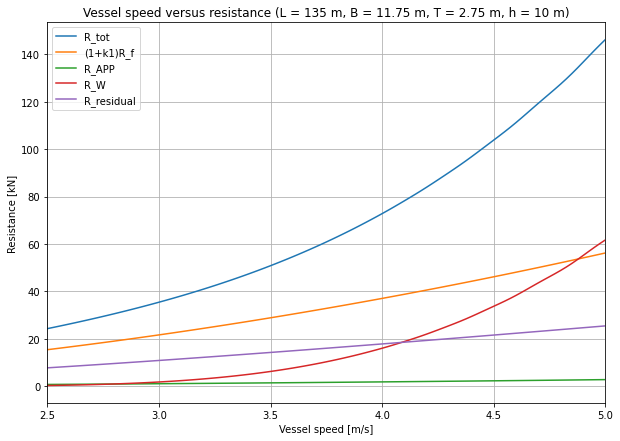

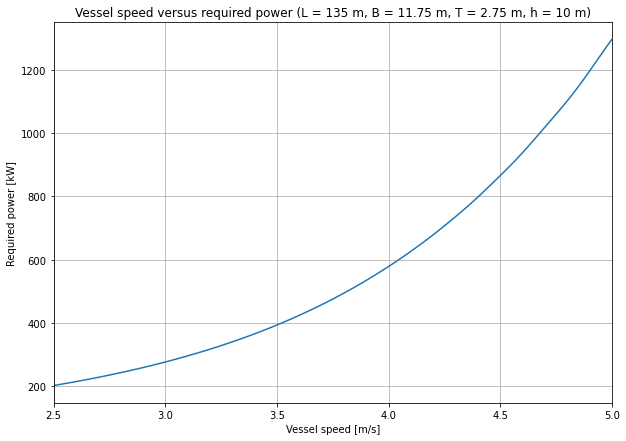

In [13]:
#When h is fixed

#Vessel speed versus resistance
plt.figure(figsize=(10,7))
plt.plot(V_0, R_tot)
plt.plot(V_0, one_k1*R_f)
plt.plot(V_0, R_APP)
plt.plot(V_0, R_W)
plt.plot(V_0, R_B + R_TR + R_A)
plt.grid()
plt.xlim(2.5, 5.0)
plt.legend(['R_tot', '(1+k1)R_f', 'R_APP', 'R_W', 'R_residual'])
plt.xlabel('Vessel speed [m/s]')
plt.ylabel('Resistance [kN]')
plt.title('Vessel speed versus resistance (L = 135 m, B = 11.75 m, T = 2.75 m, h = 10 m)')

#Vessel speed versus required power
plt.figure(figsize=(10,7))
plt.plot(V_0, P_tot)
plt.xlim(2.5, 5.0)
plt.grid()
plt.xlabel('Vessel speed [m/s]')
plt.ylabel('Required power [kW]')
plt.title('Vessel speed versus required power (L = 135 m, B = 11.75 m, T = 2.75 m, h = 10 m)')